# Atividade de Perceptron

Este notebook aborda a implementação do algoritmo **Perceptron** para classificação binária de dados 2D. O objetivo é gerar dados sintéticos, implementar o perceptron do zero utilizando apenas NumPy para operações matriciais, treinar o modelo, visualizar os resultados e discutir o desempenho em dois cenários distintos.

## O que é um Perceptron?

O perceptron é um dos modelos mais simples de rede neural artificial. Consiste em um único neurônio que recebe um vetor de entrada $x$, calcula um somatório ponderado com pesos $w$ e adiciona um termo de viés $b$. A saída é obtida através de uma função de ativação de degrau (função sinal):

$$
\text{output} =
\begin{cases}
 1 & \text{se } w \cdot x + b > 0 \\
 -1 & \text{caso contrário}
\end{cases}
$$

Esse modelo é capaz de separar linearmente duas classes de dados. Sua importância histórica reside no fato de que ele pavimentou o caminho para redes neurais mais complexas, embora seja limitado a problemas linearmente separáveis.

## Detalhes da Implementação

- **Bibliotecas utilizadas:** apenas `numpy` para cálculos matriciais e `matplotlib` para visualização.
- **Geração de dados:** para cada exercício, geramos dois conjuntos de amostras 2D (1000 amostras por classe) usando distribuições normais multivariadas com médias e matrizes de covariância especificadas.
- **Representação das classes:** as classes são rotuladas como $-1$ e $+1$ para compatibilidade com a regra de aprendizado do perceptron.
- **Regra de atualização (Perceptron Learning Rule):**
  - Para cada amostra mal classificada $(x_i, y_i)$:
    - $w \leftarrow w + \eta \cdot y_i \cdot x_i$
    - $b \leftarrow b + \eta \cdot y_i$
  - A taxa de aprendizado ($\eta$) utilizada é $0{,}01$.
- **Critério de parada:** treinamento até convergir (nenhuma atualização em uma época completa) ou até 100 épocas.
- **Visualizações:**
  - Scatter plot dos dados com cores distintas para cada classe.
  - Linha que representa a fronteira de decisão $w \cdot x + b = 0$ após o treinamento.
  - Gráfico de acurácia por época para acompanhar a convergência.
  - Destaque dos pontos mal classificados após o treinamento.



In [52]:
#############################
#######---- UTILS ----#######
#############################

import numpy as np
import matplotlib.pyplot as plt

# Função para gerar os dados
np.random.seed(42)  # Para reprodutibilidade

def generate_data(mean0, cov0, mean1, cov1, n_samples=1000):
    class0 = np.random.multivariate_normal(mean0, cov0, n_samples)
    class1 = np.random.multivariate_normal(mean1, cov1, n_samples)
    X = np.vstack((class0, class1))
    y = np.hstack((np.full(n_samples, -1), np.full(n_samples, 1)))
    return X, y

# Treinamento do perceptron
def perceptron_train(X, y, eta=0.01, max_epochs=100):
    w = np.zeros(X.shape[1])
    b = 0.0
    accuracies = []
    for epoch in range(max_epochs):
        errors = 0
        for xi, yi in zip(X, y):
            if yi * (np.dot(w, xi) + b) <= 0:
                w += eta * yi * xi
                b += eta * yi
                errors += 1
        # Calcula acurácia após a época
        preds = np.sign(np.dot(X, w) + b)
        acc = np.mean(preds == y)
        accuracies.append(acc)
        if errors == 0:
            break
    return w, b, accuracies

def perceptron_train_multiple(X, y, runs=5, eta=0.01, max_epochs=100, shuffle=True):
    """
    Executa o perceptron_train várias vezes e retorna:
    - lista de resultados por run
    - melhor run
    - média das acurácias finais
    - desvio das acurácias finais
    """
    resultados = []
    n = len(X)

    for _ in range(runs):
        if shuffle:
            idx = np.random.permutation(n)
            Xr, yr = X[idx], y[idx]
        else:
            Xr, yr = X, y

        w, b, acc = perceptron_train(Xr, yr, eta=eta, max_epochs=max_epochs)
        resultados.append({
            "w": w,
            "b": b,
            "acc_final": acc[-1],
            "epocas": len(acc),
            "acc_hist": acc
        })

    melhor = max(resultados, key=lambda d: d["acc_final"])
    media = float(np.mean([d["acc_final"] for d in resultados]))
    desvio = float(np.std([d["acc_final"] for d in resultados]))
    return resultados, melhor, media, desvio

# Função para plotar dados e fronteira de decisão
def plot_decision_boundary(X, y, w, b, title="Dados e fronteira de decisão"):
    plt.figure(figsize=(6, 6))

    # Separa classes para plotar com cores diferentes
    class0 = X[y == -1]
    class1 = X[y == 1]
    plt.scatter(class0[:, 0], class0[:, 1], color='blue', label='Classe -1', alpha=0.5)
    plt.scatter(class1[:, 0], class1[:, 1], color='red', label='Classe +1', alpha=0.5)

    # Fronteira de decisão: w0 * x + w1 * y + b = 0 => y = -(w0/w1) * x - b / w1
    if w[1] != 0:
        x_values = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 200)
        y_values = -(w[0] / w[1]) * x_values - b / w[1]
        plt.plot(x_values, y_values, 'k--', label='Fronteira de decisão')

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

# Função para plotar acurácia por época
def plot_accuracy(accuracies, title="Acurácia por época"):
    plt.figure(figsize=(6, 4))
    epochs = np.arange(1, len(accuracies) + 1)
    plt.plot(epochs, accuracies, marker='o')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Destaque dos pontos mal classificados
def plot_misclassified(X, y, w, b):
    preds = np.sign(np.dot(X, w) + b)
    misclassified = X[preds != y]
    plt.figure(figsize=(6, 6))
    class0 = X[y == -1]
    class1 = X[y == 1]
    plt.scatter(class0[:, 0], class0[:, 1], color='blue', label='Classe -1', alpha=0.5)
    plt.scatter(class1[:, 0], class1[:, 1], color='red', label='Classe +1', alpha=0.5)
    if w[1] != 0:
        x_values = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 200)
        y_values = -(w[0] / w[1]) * x_values - b / w[1]
        plt.plot(x_values, y_values, 'k--', label='Fronteira de decisão')
    if len(misclassified) > 0:
        plt.scatter(misclassified[:, 0], misclassified[:, 1], facecolors='none', edgecolors='yellow',
                    s=80, label='Misclassificados')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.title('Exercício 1: Pontos Mal Classificados')
    plt.grid(True)
    plt.show()


## Exercício 1: Dados quase linearmente separáveis

Geramos dois conjuntos de dados 2D com 1000 amostras cada. As amostras da **Classe 0** têm média $[1{,}5, 1{,}5]$ e matriz de covariância $\begin{pmatrix}0{,}5 & 0\\0 & 0{,}5\end{pmatrix}$. As amostras da **Classe 1** têm média $[5, 5]$ e a mesma matriz de covariância. Esses parâmetros produzem dados com sobreposição mínima, facilitando a separação linear.
O código abaixo gera os dados, treina o perceptron e visualiza os resultados.



In [53]:
# Parâmetros para o Exercício 1
mean0_ex1 = np.array([1.5, 1.5])
cov0_ex1 = np.array([[0.5, 0], [0, 0.5]])
mean1_ex1 = np.array([5, 5])
cov1_ex1 = np.array([[0.5, 0], [0, 0.5]])

# Geração dos dados
X1, y1 = generate_data(mean0_ex1, cov0_ex1, mean1_ex1, cov1_ex1, n_samples=1000)

# Treinamento do perceptron
w1, b1, acc1 = perceptron_train(X1, y1, eta=0.01, max_epochs=100)

Pesos finais (Exercício 1): [0.01985622 0.01711828]
Viés final (Exercício 1): -0.11999999999999998
Acurácia final (Exercício 1): 1.0
Épocas executadas (Exercício 1): 12


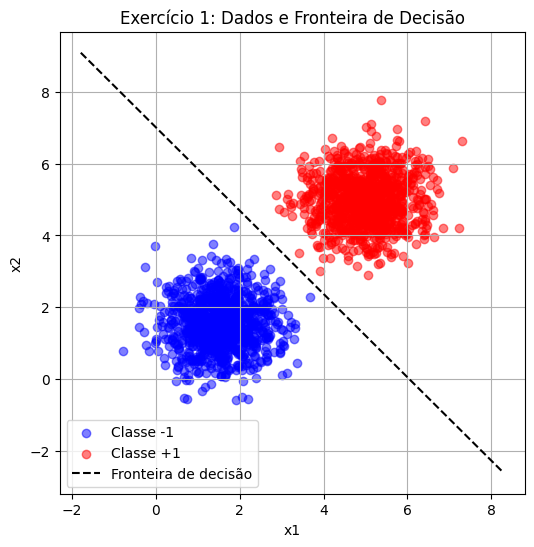

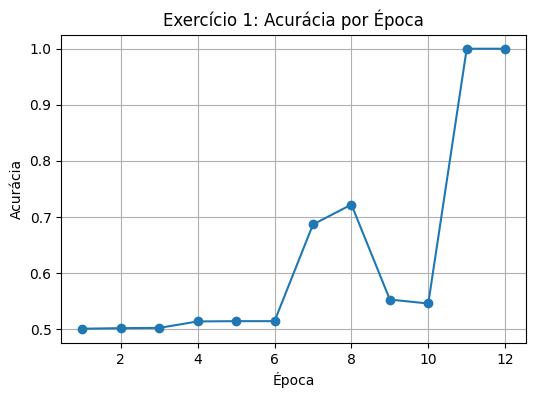

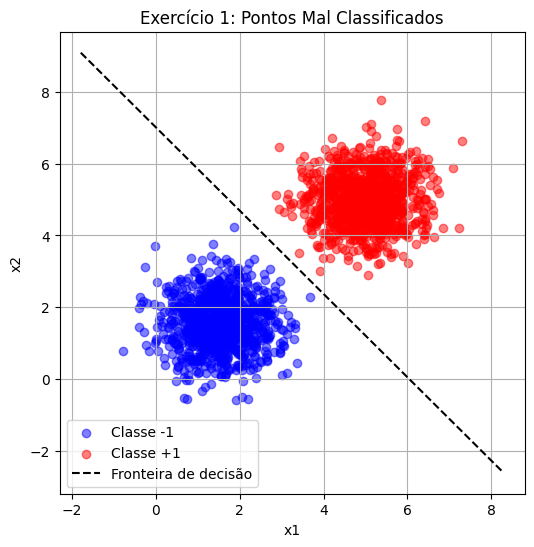

In [54]:
# Resultados do Exercício 1
print("Pesos finais (Exercício 1):", w1)
print("Viés final (Exercício 1):", b1)
print("Acurácia final (Exercício 1):", acc1[-1])
print("Épocas executadas (Exercício 1):", len(acc1))

# Plot dos dados e da fronteira de decisão
plot_decision_boundary(X1, y1, w1, b1, title="Exercício 1: Dados e Fronteira de Decisão")

# Plot da acurácia por época
plot_accuracy(acc1, title="Exercício 1: Acurácia por Época")

# Função para destacar pontos mal classificados
plot_misclassified(X1, y1, w1, b1)

### Análise dos Resultados (Exercício 1)

O treinamento do perceptron convergiu em 12 épocas, o que ainda representa um número baixo de iterações. O modelo atingiu 100 % de acurácia, refletindo que os dados são de fato quase linearmente separáveis. Os pesos finais foram aproximadamente $[0{,}0199,\;0{,}0171]$ e o viés $-0{,}12$, parâmetros que definem a fronteira de decisão mostrada nos gráficos.

Esses resultados confirmam que, com médias bem afastadas $([1{,}5,\;1{,}5] \text{ e } [5,\;5])$ e baixa variância ($0{,}5$ em cada dimensão, sem covariância), há pouquíssima sobreposição entre as classes. Isso permite ao perceptron encontrar rapidamente uma reta que separa perfeitamente os pontos das duas classes. A linha tracejada representando a fronteira de decisão divide corretamente os clusters azul e vermelho, sem pontos mal classificados.


## Exercício 2: Dados com maior sobreposição

Neste cenário, as duas classes têm médias **[3, 3]** e **[4, 4]**, e a matriz de covariância é $\begin{pmatrix}1{,}5 & 0\\0 & 1{,}5\end{pmatrix}$ para ambas. As médias são mais próximas e a variância maior, gerando **maior sobreposição** entre as classes.

O código a seguir repete o processo de geração, treinamento e visualização para esse conjunto de dados.



Pesos finais (Exercício 2): [0.03621038 0.03127034]
Viés final (Exercício 2): -0.019999999999999997
Acurácia final (Exercício 2): 0.5005
Épocas executadas (Exercício 2): 100


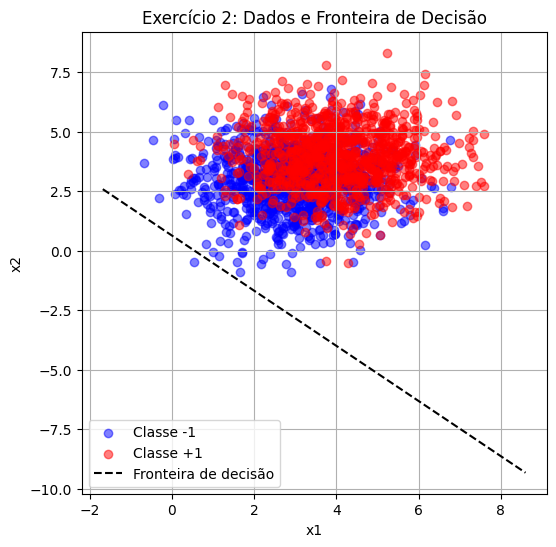

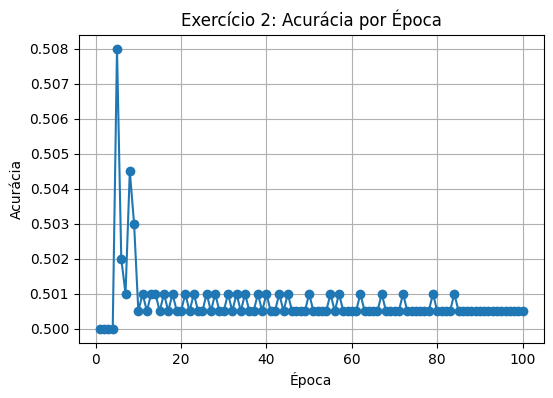

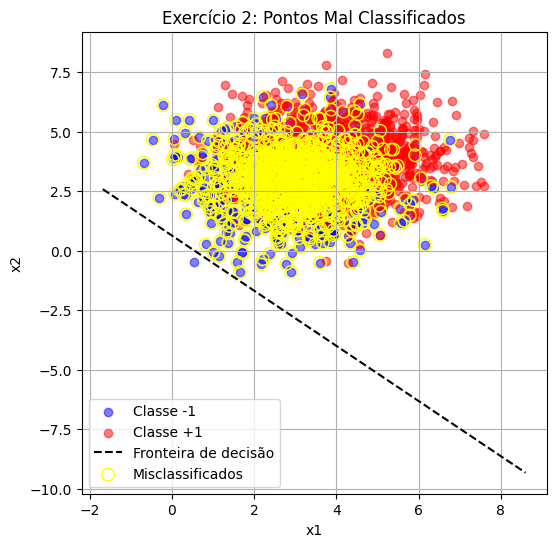

In [55]:
# Parâmetros para o Exercício 2
mean0_ex2 = np.array([3, 3])
cov0_ex2 = np.array([[1.5, 0], [0, 1.5]])
mean1_ex2 = np.array([4, 4])
cov1_ex2 = np.array([[1.5, 0], [0, 1.5]])

# Geração dos dados
X2, y2 = generate_data(mean0_ex2, cov0_ex2, mean1_ex2, cov1_ex2, n_samples=1000)

# Treinamento do perceptron
w2, b2, acc2 = perceptron_train(X2, y2, eta=0.01, max_epochs=100)

print("Pesos finais (Exercício 2):", w2)
print("Viés final (Exercício 2):", b2)
print("Acurácia final (Exercício 2):", acc2[-1])
print("Épocas executadas (Exercício 2):", len(acc2))

# Plot dos dados e da fronteira de decisão
plot_decision_boundary(X2, y2, w2, b2, title="Exercício 2: Dados e Fronteira de Decisão")

# Plot da acurácia por época
plot_accuracy(acc2, title="Exercício 2: Acurácia por Época")

# Pontos mal classificados
def plot_misclassified2(X, y, w, b):
    preds = np.sign(np.dot(X, w) + b)
    misclassified = X[preds != y]
    plt.figure(figsize=(6, 6))
    class0 = X[y == -1]
    class1 = X[y == 1]
    plt.scatter(class0[:, 0], class0[:, 1], color='blue', label='Classe -1', alpha=0.5)
    plt.scatter(class1[:, 0], class1[:, 1], color='red', label='Classe +1', alpha=0.5)
    if w[1] != 0:
        x_values = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 200)
        y_values = -(w[0] / w[1]) * x_values - b / w[1]
        plt.plot(x_values, y_values, 'k--', label='Fronteira de decisão')
    if len(misclassified) > 0:
        plt.scatter(misclassified[:, 0], misclassified[:, 1], facecolors='none', edgecolors='yellow', s=80, label='Misclassificados')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.title('Exercício 2: Pontos Mal Classificados')
    plt.grid(True)
    plt.show()

plot_misclassified2(X2, y2, w2, b2)

### Análise dos Resultados (Exercício 2) - Single Run

O segundo conjunto de dados tem classes com médias muito próximas e variância alta, o que faz os pontos azuis e vermelhos se misturarem bastante. O perceptron calcula uma reta a partir dos pesos finais $[0{,}036,\; 0{,}031]$ e viés $-0{,}02$, mas essa linha passa pelo meio do aglomerado e não separa bem as classes. Mesmo após 100 épocas a acurácia fica em torno de 50 %, praticamente um palpite aleatório, e o gráfico mostra oscilações sem melhora. Esses resultados mostram que o perceptron não é adequado para dados com grande sobreposição; seria necessário usar um modelo mais poderoso, como uma rede de múltiplas camadas ou uma SVM com kernel, para aprender uma fronteira de decisão mais complexa.

Exercício 2 - Multi Run:
  Melhor acurácia final: 0.7205
  Média: 0.6303
  Desvio: 0.0771

Pesos do melhor: [0.07839785 0.06000151]

Viés do melhor: -0.4700000000000002

Épocas do melhor: 100


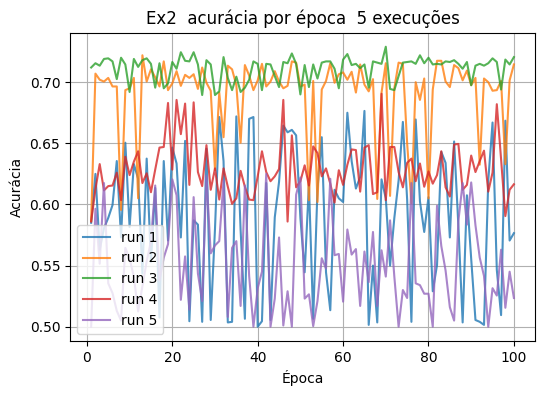

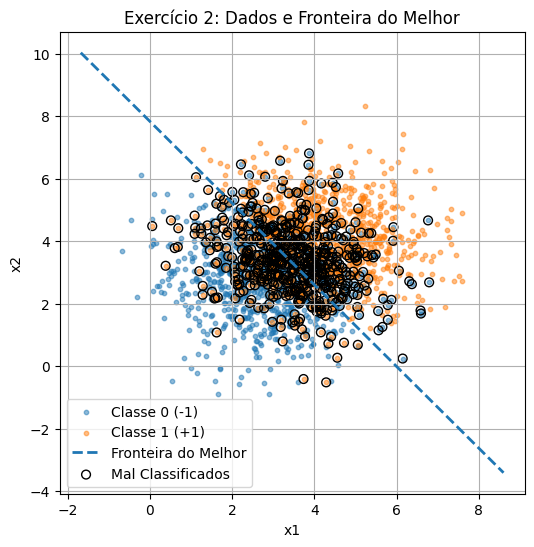

In [56]:
# Exercício 2 multi run
runs = 5
resultados, melhor, media, desvio = perceptron_train_multiple(
    X2, y2, runs=runs, eta=0.01, max_epochs=100, shuffle=True
)

print(f"Exercício 2 - Multi Run:\n  Melhor acurácia final: {melhor['acc_final']:.4f}\n  Média: {media:.4f}\n  Desvio: {desvio:.4f}")
print("")
print("Pesos do melhor:", melhor["w"])
print("")
print("Viés do melhor:", melhor["b"])
print("")
print("Épocas do melhor:", melhor["epocas"])

# Curvas de acurácia de todas as execuções
plt.figure(figsize=(6,4))
for i, s in enumerate(resultados, start=1):
    plt.plot(range(1, len(s["acc_hist"])+1), s["acc_hist"], alpha=0.8, label=f"run {i}")
plt.title("Ex2  acurácia por época  5 execuções")
plt.xlabel("Época"); plt.ylabel("Acurácia"); plt.grid(True); plt.legend()
plt.show()

# Dados com fronteira do melhor e mal classificados
w_best, b_best = melhor["w"], melhor["b"]
preds_best = np.where(X2 @ w_best + b_best >= 0.0, 1, -1)
mis = preds_best != y2

plt.figure(figsize=(6,6))
plt.scatter(X2[y2==-1,0], X2[y2==-1,1], s=10, label="Classe 0 (-1)", alpha=0.5)
plt.scatter(X2[y2== 1,0], X2[y2== 1,1], s=10, label="Classe 1 (+1)", alpha=0.5)

if abs(w_best[1]) > 1e-12:
    xs = np.linspace(X2[:,0].min()-1, X2[:,0].max()+1, 200)
    ys = -(w_best[0]/w_best[1]) * xs - b_best / w_best[1]
    plt.plot(xs, ys, linestyle="--", linewidth=2, label="Fronteira do Melhor")

plt.scatter(X2[mis,0], X2[mis,1], s=40, facecolors="none", edgecolors="k", label="Mal Classificados")

plt.title("Exercício 2: Dados e Fronteira do Melhor")
plt.xlabel("x1"); plt.ylabel("x2"); plt.grid(True); plt.legend()
plt.show()


### Referências

- **Enunciado da Atividade:** consulte o documento disponibilizado pelo curso (ANNDL - Perceptron).